In [2]:
# IMPORT
# Standard libray
import sys, os
from importlib import reload
sys.path.append("..")
import collections
import joblib


# Common library
from tqdm import tqdm
import numpy as np
import scipy
from pylab import *
import scipy.interpolate

# ROOT>....
import ROOT
# Make global style changes
ROOT.gStyle.SetOptStat(0) # Disable the statistics box
ROOT.gStyle.SetTextFont(42)
# ROOT.gStyle.SetOptFit(1111)
import atlasplots as aplt
aplt.set_atlas_style()
ROOT.gStyle.SetTitleXOffset(1)
ROOT.gStyle.SetTitleYOffset(1.8)

# Custom helper functions
import muhelper.helper_basic as hp
import helper_tofpet as hptof

reload(hp)

# ROOT.gStyle.SetPalette(len(hptof.mpl_colors), hptof.mpl_colors32)
ROOT.gStyle.SetPalette(ROOT.kViridis)
# colors=[int(c) for c in hptof.mpl_colors ]
colors=hptof.mpl_colors_cls()

Welcome to JupyROOT 6.30/04
Applying ATLAS style settings


In [3]:
# Data quality monitoring plots
# 1. singles, event rate vs time for all single_channels
# 2. singles, energy histograms for all single_channels
# 3. coinc, event rate vs time for all coinc_pairs
# 4. coinc, dt histograms for all coinc_pairs
# 5. recon, event rate vs time, overall
# 6. recon, histogram of chi2, overall

data_dir = "/mnt/sda2/tofpet_data/test_stand_init/data/"
fname_prefix= f"{data_dir}/processed/20240711_163537/20240711_163537_0"

fname_singles = f"{fname_prefix}_single.root"
fname_coinc = f"{fname_prefix}_coinc.root"
fname_recon = f"{fname_prefix}_coinc_triggered.pkl"
# Make sure all file exists
if not (os.path.exists(fname_singles) & os.path.exists(fname_coinc) & os.path.exists(fname_recon)):
    exit(0)


In [4]:
import muhelper.include_modules_root as hproot

def plot_TH1(h, labels=False, density=False):
    n,ibins,errs=hproot.get_info(h)
    xlabel=h.GetXaxis().GetTitle()
    ylabel=h.GetYaxis().GetTitle()
    if density:
        n = n/np.diff(ibins)
    plt.stairs(n,ibins)
    if labels:
        figtitle=h.GetTitle()
        gca().set_xlabel(xlabel)
        gca().set_ylabel(ylabel)
        # gca().set_title(figtitle)

In [10]:
def process_result(fname_singles, fname_coinc, fname_recon):
    """
    INPUT: 
        three filenames for single events, coincident event and reconstruction
    RETURN:
        Dictionary of plot data
    """
    #-------------------------------------------------------------------
    # Singles
    tfile = ROOT.TFile.Open(fname_singles)
    tree_name = tfile.GetListOfKeys()[0].GetName()
    Tree = tfile.Get(tree_name)
    entries = Tree.GetEntries()
    df = ROOT.RDataFrame(tree_name, fname_singles)
    df = df.Define("time_second", "time*1e-12") # Use dataframe to quickly get things into numpy
    df_keys = list(df.GetColumnNames()); print(list(df.GetColumnNames()))

    # channel list
    singles_ch_list = np.unique(df.AsNumpy(["channelID"])["channelID"])
    time_range = []
    for i in [0,entries-1]:
        Tree.GetEntry(i)
        time_range.append(Tree.time*1e-12)
    time_bins = 100
    time_bin_width = (time_range[1]-time_range[0])/time_bins
    energy_range=[-10,40]
    energy_bins=100

    print("List of single channels:", singles_ch_list, "Time range:", time_range)

    # Trigger rate and energy histograms
    hist1_single_rate={}
    hist2_single_energy={}
    for ch in singles_ch_list:
        df_filter = df.Filter(f"channelID=={ch}")
        hist1_single_rate[ch] = hproot.get_info(df_filter.Histo1D(("", f";Time [s];Rate [Hz]", time_bins, *time_range), "time_second"))
        hist2_single_energy[ch] = hproot.get_info(df_filter.Histo1D(("", f";Energy [];Counts [/{0.5:.1f}s bin]", energy_bins, *energy_range), "energy"))


    #-------------------------------------------------------------------
    # Coincidence
    tfile = ROOT.TFile.Open(fname_coinc)
    tree_name = tfile.GetListOfKeys()[0].GetName()
    Tree = tfile.Get(tree_name)
    entries = Tree.GetEntries()
    branches = [Tree.GetListOfBranches()[i].GetName() for i in range(len(Tree.GetListOfBranches()))]
    print(branches)
    df = ROOT.RDataFrame(tree_name, fname_coinc)
    df = df.Define('dt_ns', '0.001*(time1-time2)')\
        .Define('t_mean_second', '0.5*1e-12*(time1+time2)')

    # channel list
    coinc_ch_list = df.AsNumpy(["channelID1","channelID2"])
    coinc_ch_list = np.unique(np.transpose([coinc_ch_list[key1] for key1 in coinc_ch_list]), axis=0)
    print("List of coincidence channel pairs:", coinc_ch_list)
    dt_range_coinc = [-25,25]
    dt_bins_coinc = 100
    dt_bin_width_coinc = (dt_range_coinc[1]-dt_range_coinc[0])/dt_bins_coinc

    # Trigger rate and dt histograms
    hist3_coinc_rate={}
    hist4_coinc_dt={}
    for pair in coinc_ch_list:
        df_filter = df.Filter(f"channelID1=={pair[0]} && channelID2=={pair[1]}")
        hist3_coinc_rate[tuple(pair)] = hproot.get_info(df_filter.Histo1D(("", f";Time [s];Rate [Hz]", time_bins, *time_range), "t_mean_second"))
        hist4_coinc_dt[tuple(pair)]   = hproot.get_info(df_filter.Histo1D(("", f";dt [ns];Counts [/{dt_bin_width_coinc:.1f}ns bin]", dt_bins_coinc, *dt_range_coinc), "dt_ns"))


    #-------------------------------------------------------------------
    # Reconstructed
    data = joblib.load(fname_recon)
    tracks = data["tracks"]
    tracks_time = []
    tracks_chi2r = []
    for ievent in range(len(tracks)):
        for track in tracks[ievent]:
            tracks_time.append(track.t0)
            track_dof = 3*len(track.hits)-6
            tracks_chi2r.append(track.chi2/track_dof)

    hist5_tracks_time = np.histogram(tracks_time, bins=100, range=time_range)
    hist6_tracks_chi2 = np.histogram(tracks_chi2r, bins=50, range=[0,4])

    plotdata = {
        "hist1_single_rate":hist1_single_rate,
        "hist2_single_energy":hist2_single_energy,
        "hist3_coinc_rate":hist3_coinc_rate,
        "hist4_coinc_dt":hist4_coinc_dt,
        "hist5_tracks_time":hist5_tracks_time,
        "hist6_tracks_chi2":hist6_tracks_chi2,
    }

    return plotdata


In [44]:
def make_plots(plotdata, fig=None, plot_singles_list=None, plot_coinc_list=None):
    # Prepare the canvas
    if fig is None:
        fig,axes=plt.subplots(2, 3, figsize=(12, 6), dpi=100, tight_layout=True)
    else:
        axes=fig.axes


    plot_singles_list = list(plotdata["hist1_single_rate"].keys()) if plot_singles_list is None else plot_singles_list
    plot_coinc_list = list(plotdata["hist3_coinc_rate"].keys()) if plot_coinc_list is None else plot_coinc_list

    for i, ax in enumerate(axes):
        ax.tick_params(axis="x", direction='in', pad = 3)
        ax.tick_params(axis="y", direction='in', pad = 3)

    # 1. singles trigger rate
    sca(axes[0])
    if len(plot_singles_list)>0:
        for ch in plot_singles_list:
            stairs(plotdata["hist1_single_rate"][ch][0],plotdata["hist1_single_rate"][ch][1])
    xlabel("Time [s]")
    ylabel("Rate [Hz]", labelpad=0)
    text(0.98, 0.9, 'Singles rate', horizontalalignment='right',
     verticalalignment='center', transform=gca().transAxes, fontsize=16, fontweight="bold")            
    margins(x=0, y=0)


    # 2. singles energy
    sca(axes[3])
    if len(plot_singles_list)>0:
        for ch in plot_singles_list[:-1]:
            stairs(plotdata["hist2_single_energy"][ch][0],plotdata["hist2_single_energy"][ch][1])
    xlabel("Energy [s]")
    ylabel("Counts", labelpad=0)
    text(0.98, 0.9, 'Singles energy', horizontalalignment='right',
     verticalalignment='center', transform=gca().transAxes, fontsize=16, fontweight="bold")                    
    margins(x=0, y=0)

    # 3. coinc trigger rate
    sca(axes[1])
    if len(plot_coinc_list)>0:
        for ch in plot_coinc_list[:-1]:
            stairs(plotdata["hist3_coinc_rate"][ch][0],plotdata["hist3_coinc_rate"][ch][1])
    xlabel("Time [s]")
    ylabel("Rate [Hz]", labelpad=0)
    text(0.98, 0.9, 'coinc rate', horizontalalignment='right',
     verticalalignment='center', transform=gca().transAxes, fontsize=16, fontweight="bold", color="C1")        
    margins(x=0, y=0)


    # 4. coinc dt
    sca(axes[4])
    if len(plot_coinc_list)>0:
        for ch in plot_coinc_list[:-1]:
            stairs(plotdata["hist4_coinc_dt"][ch][0],plotdata["hist4_coinc_dt"][ch][1])
    xlabel("$\delta$t [ns]")
    ylabel("Counts", labelpad=0)
    text(0.98, 0.9, 'coinc dt', horizontalalignment='right',
     verticalalignment='center', transform=gca().transAxes, fontsize=16, fontweight="bold", color="C1")                    
    margins(x=0, y=0)


    # 5. Tracks rate
    sca(axes[3])
    n,ibins = plotdata["hist5_tracks_time"]
    stairs(n,ibins)
    xlabel("Time [s]")
    ylabel("Rate [Hz]", labelpad=0)
    text(0.98, 0.9, 'track rate', horizontalalignment='right',
     verticalalignment='center', transform=gca().transAxes, fontsize=16, fontweight="bold", color="C2")      
    margins(x=0, y=0)

    # 5. Tracks chi2
    sca(axes[5])
    n,ibins = plotdata["hist6_tracks_chi2"]
    stairs(n,ibins)
    xlabel("$\chi^2$/DOF")
    ylabel("Counts", labelpad=0)
    text(0.98, 0.9, 'track chi2', horizontalalignment='right',
     verticalalignment='center', transform=gca().transAxes, fontsize=16, fontweight="bold", color="C2")    
    margins(x=0, y=0)

    return fig


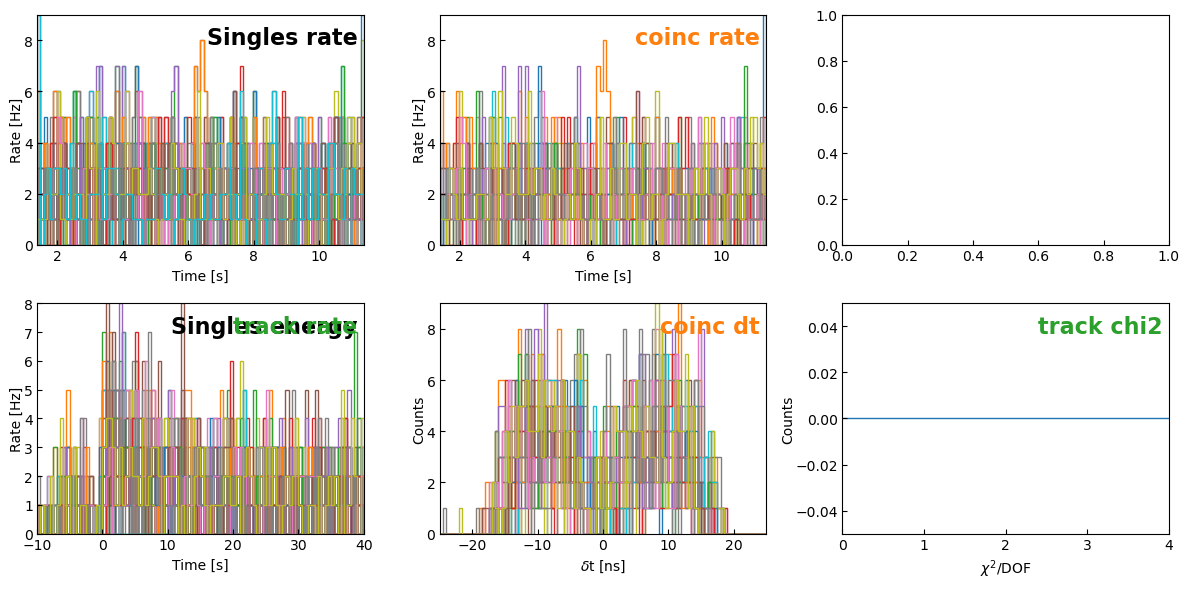

In [45]:
fig,axes=plt.subplots(2, 3, figsize=(12, 6), dpi=100, tight_layout=True)
fig = make_plots(plotdata, fig=fig, plot_singles_list=None, plot_coinc_list=None)


['channelID', 'energy', 'step1', 'step2', 'tacID', 'time', 'time_second', 'tot', 'tqE', 'tqT', 'x', 'xi', 'y', 'yi', 'z']
List of single channels: [  2   9  11  13  27  38  58  59  61  62  66  73  75  77  91 102 122 123
 125 126 258 265 267 269 283 294 314 315 317 318 320 321 323 325 327 328
 330 332 334 335] Time range: [1.378881358271, 11.368532461578999]
['step1', 'step2', 'mh_n1', 'mh_j1', 'tot1', 'time1', 'channelID1', 'energy1', 'tacID1', 'xi1', 'yi1', 'x1', 'y1', 'z1', 'mh_n2', 'mh_j2', 'time2', 'channelID2', 'tot2', 'energy2', 'tacID2', 'xi2', 'yi2', 'x2', 'y2', 'z2']
List of coincidence channel pairs: [[258  61]
 [265  38]
 [267  58]
 [269  59]
 [283  62]
 [294   9]
 [314  11]
 [315  13]
 [317   2]
 [318  27]
 [320 125]
 [321 123]
 [323 126]
 [325 102]
 [327  75]
 [328  66]
 [330 122]
 [332  73]
 [334  91]
 [335  77]]


['/mnt/sda2/tofpet_data/test_stand_init/data//processed/20240711_163537/20240711_163537_0_data_quality.joblib']

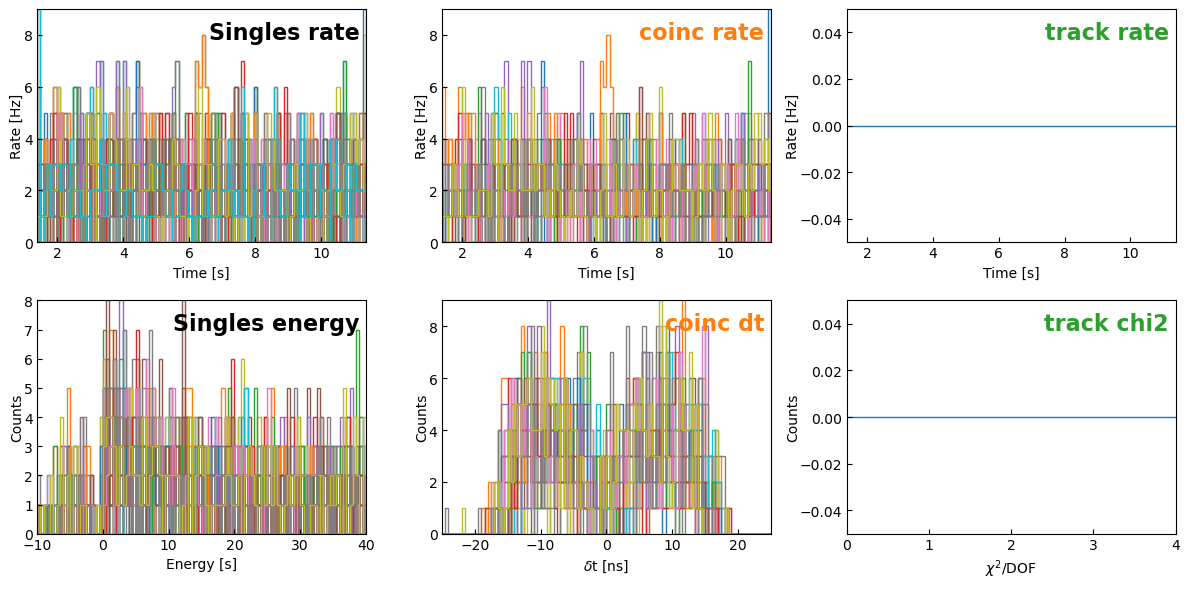

In [42]:
# Run processing
plotdata = process_result(fname_singles, fname_coinc, fname_recon)
# Make plots
fig = make_plots(plotdata, fig=None, plot_singles_list=None, plot_coinc_list=None)

# Save the processed result and plot
fig.savefig(fname_singles.replace("single.root", "data_quality.jpg"))
joblib.dump(plotdata, fname_singles.replace("single.root", "data_quality.joblib"))
